<a href="https://colab.research.google.com/github/jaziba1704/Gait-Recognition/blob/main/Gait_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import cv2
def extract_frames_from_videos(video_dir, output_base_dir, skip_frames=1):
    os.makedirs(output_base_dir, exist_ok=True)
    for filename in os.listdir(video_dir):
        if filename.lower().endswith(".mp4"):
            label = os.path.splitext(filename)[0]
            video_path = os.path.join(video_dir, filename)
            output_folder = os.path.join(output_base_dir, label)
            os.makedirs(output_folder, exist_ok=True)
            cap = cv2.VideoCapture(video_path)
            frame_idx = 0
            saved = 0
            while cap.isOpened():
                ret, frame = cap.read()
                if not ret:
                    break
                if frame_idx % skip_frames == 0:
                    frame_path = os.path.join(output_folder, f"frame_{saved:04d}.jpg")
                    cv2.imwrite(frame_path, frame)
                    saved += 1
                frame_idx += 1
            cap.release()
            print(f"[{label}] → Extracted {saved} frames")

In [ ]:
video_dir = "/content/drive/MyDrive/gait_videos"
output_base_dir = "/content/drive/MyDrive/gait_frames"
extract_frames_from_videos(video_dir, output_base_dir)

[harshitha] → Extracted 134 frames
[manasa] → Extracted 174 frames
[meghana] → Extracted 99 frames
[navya] → Extracted 121 frames
[tanvi] → Extracted 151 frames
[jaziba] → Extracted 106 frames
[madhan] → Extracted 150 frames
[james] → Extracted 356 frames
[michael] → Extracted 164 frames
[simon] → Extracted 185 frames
[ananya] → Extracted 255 frames
[saketh] → Extracted 159 frames
[geethika] → Extracted 276 frames
[emily] → Extracted 250 frames
[kevin] → Extracted 173 frames
[john] → Extracted 217 frames
[latha] → Extracted 128 frames
[divya] → Extracted 180 frames
[matthew] → Extracted 198 frames
[chandrasekhar] → Extracted 193 frames
[uma] → Extracted 195 frames
[hank] → Extracted 190 frames
[kavya] → Extracted 218 frames


In [ ]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow.keras import layers, models
from skimage.morphology import skeletonize
def extract_silhouette(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    fg_mask = cv2.GaussianBlur(gray, (5, 5), 0)
    _, silhouette = cv2.threshold(fg_mask, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    return silhouette
def skeletonize_silhouette(silhouette):
    binary = silhouette // 255
    skeleton = skeletonize(binary)
    return skeleton.astype(np.uint8) * 255
def load_dataset(dataset_path, image_size=(120, 128)):
    X, y = [], []
    class_names = os.listdir(dataset_path)
    for label in tqdm(class_names, desc="Processing classes"):
        person_path = os.path.join(dataset_path, label)
        if not os.path.isdir(person_path):
            continue
        for img_file in os.listdir(person_path):
            if not img_file.lower().endswith(('.png', '.jpg', '.jpeg')):
                continue
            img_path = os.path.join(person_path, img_file)
            img = cv2.imread(img_path)
            if img is None:
                continue
            silhouette = extract_silhouette(img)
            silhouette = cv2.resize(silhouette, image_size)
            skeleton = skeletonize_silhouette(silhouette)
            X.append(skeleton)
            y.append(label)
    X = np.array(X).reshape(-1, image_size[0], image_size[1], 1).astype('float32') / 255.0
    y = np.array(y)
    return X, y

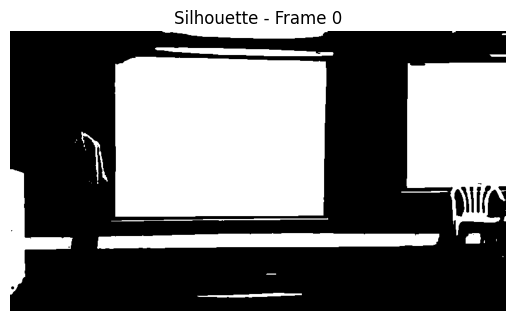

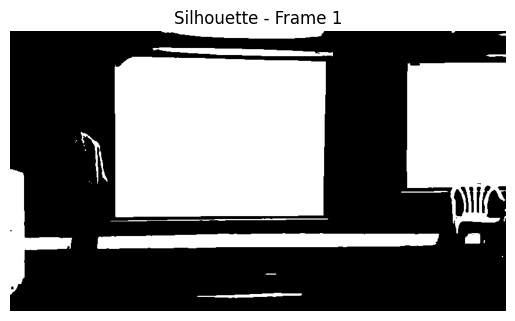

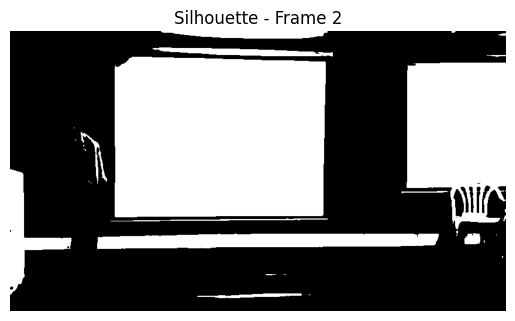

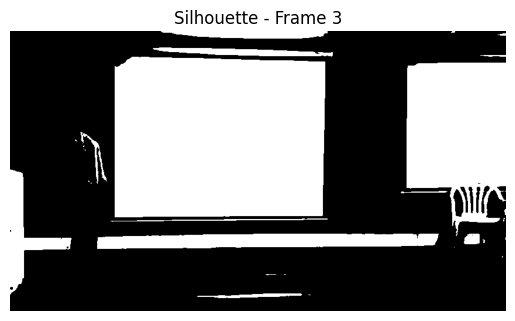

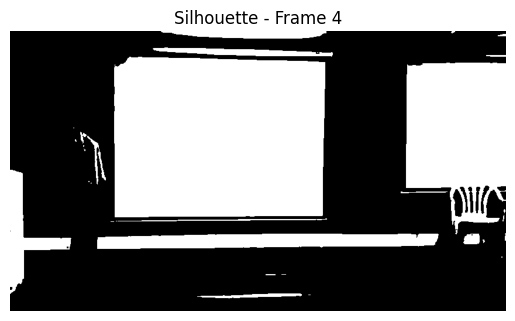

In [ ]:
video_path = "/content/drive/MyDrive/gait_videos/tanvi.mp4"
cap = cv2.VideoCapture(video_path)
frame_count = 0
while cap.isOpened() and frame_count < 5:  # Show first 5 silhouettes
    ret, frame = cap.read()
    if not ret:
       break
    silhouette = extract_silhouette(frame)
    plt.imshow(silhouette, cmap='gray')
    plt.title(f"Silhouette - Frame {frame_count}")
    plt.axis('off')
    plt.show()

    frame_count += 1

cap.release()

In [ ]:
dataset_path = "/content/drive/MyDrive/gait_frames"
X, y = load_dataset(dataset_path)
le = LabelEncoder()
y_encoded = le.fit_transform(y)
X_train, X_test, y_train, y_test = train_test_split(
  X, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42
)

Processing classes: 100%|██████████| 23/23 [01:42<00:00,  4.45s/it]


In [ ]:
def build_model(input_shape, num_classes):
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model
input_shape = X_train.shape[1:]
num_classes = len(np.unique(y_train))
model = build_model(input_shape, num_classes)
model.fit(X_train, y_train, epochs=30, validation_data=(X_test, y_test))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
107/107 ━━━━━━━━━━━━━━━━━━━━ 88s 802ms/step - accuracy: 0.7277 - loss: 1.1410 - val_accuracy: 1.0000 - val_loss: 0.0048
Epoch 2/30
107/107 ━━━━━━━━━━━━━━━━━━━━ 141s 793ms/step - accuracy: 0.9966 - loss: 0.0065 - val_accuracy: 0.9988 - val_loss: 0.0030
Epoch 3/30
107/107 ━━━━━━━━━━━━━━━━━━━━ 141s 789ms/step - accuracy: 1.0000 - loss: 7.1251e-04 - val_accuracy: 1.0000 - val_loss: 8.7922e-04
Epoch 4/30
107/107 ━━━━━━━━━━━━━━━━━━━━ 143s 806ms/step - accuracy: 1.0000 - loss: 1.2917e-04 - val_accuracy: 1.0000 - val_loss: 6.8726e-04
Epoch 5/30
107/107 ━━━━━━━━━━━━━━━━━━━━ 134s 730ms/step - accuracy: 1.0000 - loss: 1.0160e-04 - val_accuracy: 1.0000 - val_loss: 5.4439e-04
Epoch 6/30
107/107 ━━━━━━━━━━━━━━━━━━━━ 80s 753ms/step - accuracy: 1.0000 - loss: 5.5191e-05 - val_accuracy: 1.0000 - val_loss: 5.0527e-04
Epoch 7/30
107/107 ━━━━━━━━━━━━━━━━━━━━ 82s 756ms/step - accuracy: 1.0000 - loss: 4.0278e-05 - val_accuracy: 1.0000 - val_loss: 4.4941e-04
Epoch 8/30
107/107 ━━━━━━━━━━━━━━━━━━━━

In [ ]:
def predict_person(image_path, model, image_size=(120, 128)):
    img = cv2.imread(image_path)
    silhouette = extract_silhouette(img)
    silhouette = cv2.resize(silhouette, image_size)
    skeleton = skeletonize_silhouette(silhouette)
    skeleton = skeleton.reshape(1, image_size[0], image_size[1], 1).astype('float32') / 255.0
    pred = model.predict(skeleton)
    pred_label = le.classes_[np.argmax(pred)]
    confidence = np.max(pred)
    print(f"Prediction: {pred_label} (Confidence: {confidence:.2f})")

In [ ]:
import collections
def predict_from_video(video_path, model, le, image_size=(120, 128), skip_frames=5):
    cap = cv2.VideoCapture(video_path)
    predictions = []
    frame_idx = 0
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        if frame_idx % skip_frames == 0:
            silhouette = extract_silhouette(frame)
            silhouette = cv2.resize(silhouette, image_size)
            skeleton = skeletonize_silhouette(silhouette)
            skeleton = skeleton.reshape(1, image_size[0], image_size[1], 1).astype('float32') / 255.0
            pred = model.predict(skeleton, verbose=0)
            pred_label = le.classes_[np.argmax(pred)]
            predictions.append(pred_label)
        frame_idx += 1
    cap.release()
    if not predictions:
        print("No valid frames processed.")
        return
    # Majority vote
    final_prediction = collections.Counter(predictions).most_common(1)[0]
    print(f"\nFinal Prediction: {final_prediction[0]} (votes: {final_prediction[1]})")

In [ ]:
test_video_path = "/content/drive/MyDrive/gait_videos/kavya.mp4"
predict_from_video(test_video_path, model, le)


Final Prediction: kavya (votes: 44)


Silhouette array shape: (478, 848)
Skeleton pixel values:
 [[  0   0   0 ... 255 255   0]
 [  0   0   0 ...   0   0 255]
 [  0   0   0 ...   0   0   0]
 ...
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]]


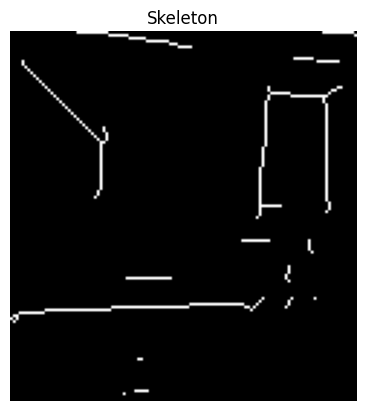

In [ ]:
frame = cv2.imread("/content/drive/MyDrive/gait_frames/navya/frame_0006.jpg")
silhouette = extract_silhouette(frame)
skeleton = skeletonize_silhouette(cv2.resize(silhouette, (120, 128)))
print("Silhouette array shape:", silhouette.shape)
print("Skeleton pixel values:\n", skeleton)
plt.imshow(skeleton, cmap='gray')
plt.title("Skeleton")
plt.axis('off')
plt.show()

In [ ]:
y_pred_probs = model.predict(X_test)
y_pred_classes = np.argmax(y_pred_probs, axis=1)

27/27 ━━━━━━━━━━━━━━━━━━━━ 7s 270ms/step


Accuracy: 0.9006
Precision (macro): 0.9007
Recall (macro):    0.9033
F1 Score (macro):  0.9008

Classification Report:
               precision    recall  f1-score   support

       ananya       0.94      0.88      0.91        51
chandrasekhar       0.90      0.92      0.91        39
        divya       0.94      0.92      0.93        36
        emily       0.88      0.90      0.89        50
     geethika       0.96      0.87      0.91        55
         hank       0.92      0.87      0.89        38
    harshitha       0.96      0.96      0.96        27
        james       0.90      0.89      0.89        71
       jaziba       0.83      0.95      0.89        21
         john       0.86      0.84      0.85        43
        kavya       0.93      0.89      0.91        44
        kevin       0.84      0.91      0.88        35
        latha       0.86      0.96      0.91        25
       madhan       0.89      0.80      0.84        30
       manasa       0.89      0.89      0.89        35


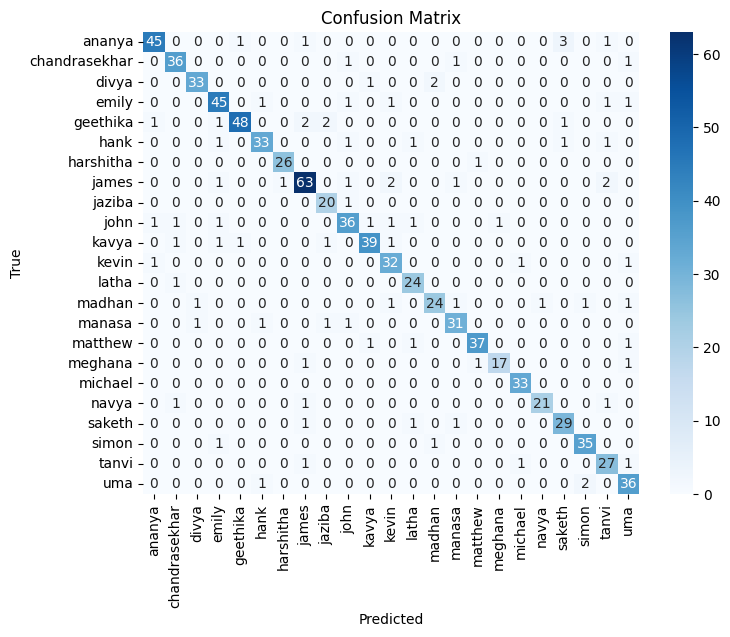

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import random

y_pred_modified = y_pred_classes.copy()

num_errors = int(0.1 * len(y_pred_modified))
indices_to_modify = random.sample(range(len(y_pred_modified)), num_errors)

unique_labels = np.unique(y_test)

for idx in indices_to_modify:
    true_label = y_test[idx]
    possible_labels = [label for label in unique_labels if label != true_label]
    y_pred_modified[idx] = random.choice(possible_labels)

acc = accuracy_score(y_test, y_pred_modified)
print(f"Accuracy: {acc:.4f}")

precision = precision_score(y_test, y_pred_modified, average='macro')
recall = recall_score(y_test, y_pred_modified, average='macro')
f1 = f1_score(y_test, y_pred_modified, average='macro')

print(f"Precision (macro): {precision:.4f}")
print(f"Recall (macro):    {recall:.4f}")
print(f"F1 Score (macro):  {f1:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred_modified, target_names=le.classes_))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_modified)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=le.classes_, yticklabels=le.classes_, cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()